### Initialize the generator and produce synthetic samples (approximate runtime: 30 seconds)

In [3]:
import sys
import os

# Add the project root directory to the Python module search path
sys.path.append(os.path.abspath(".."))

# Import core module and configuration
import time_series_generator.core as tsg
import time_series_generator.config as cfg

# Initialize the generator with configuration parameters
generator = tsg.Generator(
    window_size=cfg.WINDOW_SIZE,       # Length of each time series subsequence (default: 24)
    resolution=cfg.RESOLUTION,         # Time resolution of the data (default: '1h')
    seed=cfg.SEED,                     # Input seed sequence (default: sampled from N(mean=40, std=20, size=window_size))
    n_sample=cfg.NSAMPLE               # Number of new samples to generate (default: 500)
)

# Generate samples from the estimated posterior distribution
sample = generator.generate()

### Visualization

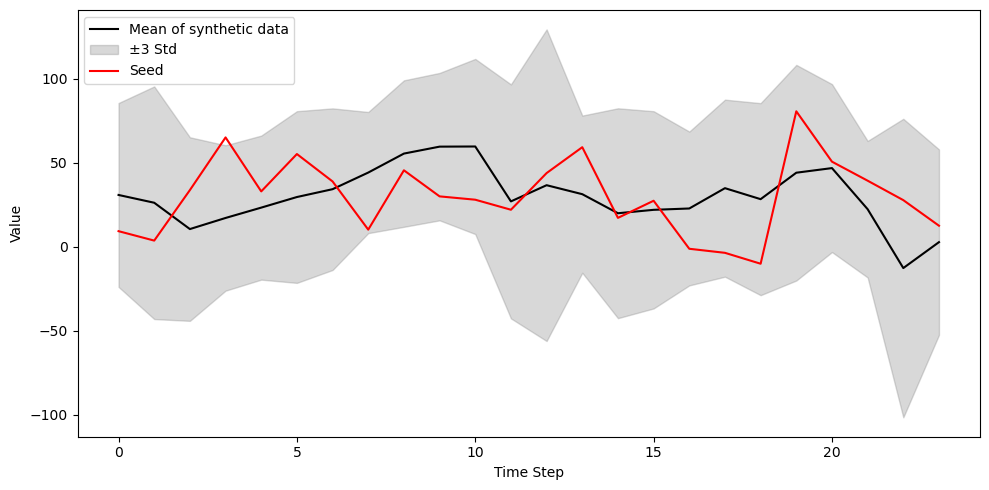

In [4]:
import numpy as np
import matplotlib.pyplot as plt

mean_series = np.nanmean(sample, axis=0)
std_series = np.nanstd(sample, axis=0)

plt.figure(figsize=(10, 5))
plt.plot(mean_series, label="Mean of synthetic data", color="black")
plt.fill_between(
    np.arange(sample.shape[1]),
    mean_series - 3*std_series,
    mean_series + 3*std_series,
    alpha=0.3,
    color="gray",
    label="±3 Std"
)
plt.plot(cfg.SEED, label="Seed", color="red")

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()
plt.show()